In [ ]:
import jax
import jax.random
import jax.numpy as jnp
from jax import jit, vmap, Array

import equinox as eqx
import equinox.nn as nn
from equinox import filter_jit, filter_value_and_grad

import optax

import matplotlib.pyplot as plt

from einops import rearrange, repeat, einsum
from dataclasses import dataclass
from typing import List, Tuple, NamedTuple

In [ ]:
def truncated_normal_initializer(key, shape):
    assert len(shape) >= 2
    return jax.random.truncated_normal(key, -2, 2, shape) / jnp.sqrt(shape[-2]) * 0.87962566103423978

In [ ]:
@dataclass(frozen=True)
class Mamba2Args:
    d_model: int
    n_heads: int 
    n_layers: int
    vocab_size: int
    seq_len: int
    d_state: int = 64
    d_conv: int = 4
    expand: int = 2
    A_init_range: Tuple[int, int] = (1, 16)
    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_scale: float = 1.0
    dt_init_floor: float = 1e-4
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        object.__setattr__(self, 'd_inner', self.expand * self.d_model)
        assert self.d_inner % self.n_heads == 0
        object.__setattr__(self, 'd_head', self.d_inner // self.n_heads)

        object.__setattr__(self, 'd_win', 2 * self.d_inner + 2 * self.d_state + self.n_heads)
        object.__setattr__(self, 'conv_dim', self.d_inner + 2 * self.d_state)


def segsum(x):
    seq_len = x.shape[-1]

    x = jnp.repeat(x[..., None], seq_len, axis=-1) 
    mask = jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool), k=-1)
    x = jnp.where(mask, x, 0)

    x_segsum = jnp.cumsum(x, axis=-2)
    mask = jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool), k=0)
    x_segsum = jnp.where(mask, x_segsum, -jnp.inf)
    
    return x_segsum


class Mamba2Layer(eqx.Module):
    norm_in: nn.RMSNorm
    norm_out: nn.RMSNorm
    win: nn.Linear
    conv: Array
    conv_bias: Array | None 
    dt_bias: Array
    A_log: Array
    D: Array
    wout: nn.Linear
    ffn_in: nn.Linear
    ffn_out: nn.Linear
    args: Mamba2Args

    def __init__(self, key, args):
        win_key, wout_key, conv_key, dt_key, A_key, ffn_in_key, ffn_out_key = jax.random.split(key, 7)
        self.args = args

        A_min, A_max = args.A_init_range
        assert A_min > 0 and A_max >= A_min
        
        self.norm_in = nn.RMSNorm(args.d_model)
        self.norm_out = nn.RMSNorm(args.d_inner)

        self.win = nn.Linear(args.d_model, args.d_win, use_bias=args.bias, key=win_key)
        self.wout = nn.Linear(args.d_inner, args.d_model, use_bias=args.bias, key=wout_key)
        
        self.conv = truncated_normal_initializer(conv_key, (args.conv_dim, args.d_conv))
        self.conv_bias = jnp.zeros(args.conv_dim) if args.conv_bias else None
        
        dt = jax.random.uniform(dt_key, (args.n_heads,))
        dt = jnp.exp(dt * (jnp.log(args.dt_max) - jnp.log(args.dt_min)) + jnp.log(args.dt_min))
        dt = dt.clip(min=args.dt_init_floor)
        self.dt_bias = dt + jnp.log(-jnp.expm1(-dt))
        
        self.A_log = jnp.log(jax.random.uniform(A_key, (args.n_heads,), minval=A_min, maxval=A_max))
        self.D = jnp.ones((args.n_heads,))

        self.ffn_in = nn.Linear(args.d_model, 4 * args.d_model, use_bias=False, key=ffn_in_key)
        self.ffn_out = nn.Linear(4 * args.d_model, args.d_model, use_bias=False, key=ffn_out_key)

    def __call__(self, x):
        x = vmap(self.norm_in)(x)

        zxBCdt = vmap(self.win)(x)

        z, xBC, dt = jnp.split(zxBCdt, [self.args.d_inner, self.args.d_inner + self.args.conv_dim], -1)

        xBC = jnp.concatenate([jnp.zeros((self.args.d_conv - 1, self.args.conv_dim)), xBC], 0).T
        xBC = vmap(jnp.convolve, (0, 0, None))(xBC, self.conv, 'valid').T 

        if self.conv_bias is not None:
            xBC = xBC + self.conv_bias

        xBC = jax.nn.silu(xBC)
        
        x, B, C = jnp.split(xBC, [self.args.d_inner, self.args.d_inner + self.args.d_state], -1)

        y = self.ssd(dt, x, B, C)
        
        y = vmap(self.norm_out)(y * jax.nn.silu(z))

        y = vmap(self.wout)(y)

        return vmap(self.ffn_out)(vmap(self.ffn_in)(y))
    
    def ssd(self, dt, x, B, C):
        x = rearrange(x, 'l (nh dh) -> nh l dh', nh=self.args.n_heads)
        dt = jax.nn.softplus(dt + self.dt_bias)
        xdt = einsum(x, dt, 'nh l dh, l nh -> nh l dh')  
        Adt = -jnp.exp(self.A_log) * dt
        
        L = jnp.exp(segsum(Adt.T))
        M = L * (C @ B.T)
        y = M @ xdt + einsum(x, self.D, 'nh l dh, nh -> nh l dh')

        return rearrange(y, 'nh l dh -> l (nh dh)')

    def step(self, x, state=None):

        if state is None:
            state = (
                jnp.zeros((self.args.conv_dim, self.args.d_conv - 1)),
                jnp.zeros((self.args.n_heads, self.args.d_head, self.args.d_state))
            )

        conv_state, ssm_state = state

        x = self.norm_in(x)

        zxBCdt = self.win(x) 

        z, xBC, dt = jnp.split(zxBCdt, [self.args.d_inner, self.args.d_inner + self.args.conv_dim], -1)

        conv_input = jnp.concatenate([conv_state, xBC[:, None]], -1)
        xBC = jnp.vecdot(conv_input, jnp.flip(self.conv, -1))

        if self.conv_bias is not None:
            xBC = xBC + self.conv_bias

        xBC = jax.nn.silu(xBC)

        x, B, C = jnp.split(xBC, [self.args.d_inner, self.args.d_inner + self.args.d_state], -1)

        dt = jax.nn.softplus(dt + self.dt_bias)
        x = rearrange(x, '(nh dh) -> nh dh', nh=self.args.n_heads)

        dA = jnp.exp(-jnp.exp(self.A_log) * dt)
        dBx = einsum(B, x, dt, 'n, nh dh, nh -> nh dh n')

        ssm_state = einsum(dA, ssm_state, 'nh, nh dh n -> nh dh n') + dBx 
        y = ssm_state @ C.T + einsum(x, self.D, 'nh dh, nh -> nh dh')

        y = rearrange(y, 'nh dh -> (nh dh)') 

        y = self.norm_out(y * jax.nn.silu(z))

        y = self.wout(y)

        return self.ffn_out(self.ffn_in(y)), (conv_input[:, 1:], ssm_state)


class Mamba2(eqx.Module):
    wte: Array
    wout: nn.Linear
    layers: List[Mamba2Layer]
    norm: nn.RMSNorm
    args: Mamba2Args
    
    def __init__(self, key, args):
        wte_key, wout_key, layers_key = jax.random.split(key, 3)
        assert args.d_model > args.seq_len
        self.args = args
        self.wte = truncated_normal_initializer(wte_key, (args.vocab_size, args.d_model - args.seq_len))
        self.layers = [Mamba2Layer(subkey, args) for subkey in jax.random.split(layers_key, args.n_layers)]
        self.norm = nn.RMSNorm(args.d_model)
        self.wout = nn.Linear(args.d_model, args.vocab_size, use_bias=False, key=wout_key)
    
    def __call__(self, tokens):
        seq_len = tokens.shape[0]
        x = jnp.concatenate([self.wte[tokens], jnp.eye(seq_len, self.args.seq_len)], -1)

        for layer in self.layers:
            x = x + layer(x)

        return vmap(self.wout)(vmap(self.norm)(x))
    
    @filter_jit
    def step(self, token, position, state=None):
        if state is None:
            state = [None] * self.args.n_layers
        
        x = jnp.concatenate([self.wte[token], jax.nn.one_hot(position, self.args.seq_len)], -1)

        next_state = []
        for layer, layer_state in zip(self.layers, state):
            h, next_layer_state = layer.step(x, layer_state)
            x = x + h
            next_state.append(next_layer_state)

        return self.wout(self.norm(x)), next_state

    def generate(self, steps, tokens, key=None):
        
        def select_token(logits, key):
            if key is None:
                return logits.argmax(), key
            else:
                key, subkey = jax.random.split(key)
                return jax.random.categorical(subkey, logits), key

        position = jnp.array(0)
        state = None

        for token in tokens:
            logits, state = self.step(token, position, state)
            position = position + 1
        
        token, key = select_token(logits, key)
        yield token 
        
        for _ in range(steps - 1):
            logits, state = self.step(token, position, state)
            position = position + 1
            token, key = select_token(logits, key)
            yield token

In [ ]:
class TransformerArgs(NamedTuple):
    d_model: int
    n_heads: int
    n_layers: int
    vocab_size: int
    seq_len: int


class AttentionLayer(eqx.Module):
    win: nn.Linear
    wout: nn.Linear
    n_heads: int

    def __init__(self, key, d_model, n_heads):
        win_key, wout_key = jax.random.split(key)
        self.n_heads = n_heads
        self.win = nn.Linear(d_model, 3 * d_model, use_bias=False, key=win_key)
        self.wout = nn.Linear(d_model, d_model, use_bias=False, key=wout_key)

    def __call__(self, x, mask):
        q, k, v = rearrange(vmap(self.win)(x), 'l (n nh dh) -> n nh l dh', n=3, nh=self.n_heads)
        scores = q @ k.transpose(0, 2, 1)
        heads = jax.nn.softmax(scores / jnp.sqrt(self.n_heads) + mask, -1) @ v
        return vmap(self.wout)(rearrange(heads, 'nh l dh -> l (nh dh)'))


class FFN(eqx.Module):
    win: nn.Linear
    wout: nn.Linear

    def __init__(self, key, d_model):
        win_key, wout_key = jax.random.split(key)
        self.win = nn.Linear(d_model, 4 * d_model, use_bias=False, key=win_key)
        self.wout = nn.Linear(4 * d_model, d_model, use_bias=False, key=wout_key)

    def __call__(self, x):
        return self.wout(jax.nn.relu(self.win(x)))


class TransformerLayer(eqx.Module):
    attention_norm: nn.RMSNorm
    attention: AttentionLayer
    ffn_norm: nn.RMSNorm
    ffn: FFN

    def __init__(self, key, d_model, n_heads):
        att_key, ffn_key = jax.random.split(key)
        self.attention_norm = nn.RMSNorm(d_model, use_weight=True)
        self.attention = AttentionLayer(att_key, d_model, n_heads)
        self.ffn_norm = nn.RMSNorm(d_model, use_weight=True)
        self.ffn = FFN(ffn_key, d_model)

    def __call__(self, x, mask):
        h = vmap(self.attention_norm)(x)
        x = x + self.attention(h, mask)
        h = vmap(self.ffn_norm)(x)
        return x + vmap(self.ffn)(h)


class Transformer(eqx.Module):
    wte: Array
    layers: List[TransformerLayer]
    norm: nn.RMSNorm
    wout: nn.Linear
    args: TransformerArgs

    def __init__(self, key, args):
        wte_key, wout_key, layers_key = jax.random.split(key, 3)
        layers_keys = jax.random.split(layers_key, args.n_layers)
        self.args = args

        self.wte = truncated_normal_initializer(wte_key, (args.vocab_size, args.d_model - args.seq_len))
        self.layers = [TransformerLayer(subkey, args.d_model, args.n_heads) for subkey in layers_keys]
        self.norm = nn.RMSNorm(args.d_model, use_weight=True)
        self.wout = nn.Linear(args.d_model, args.vocab_size, use_bias=False, key=wout_key)

    def __call__(self, tokens):
        seq_len = tokens.shape[0]
        mask = jnp.triu(jnp.full((seq_len, seq_len), -jnp.inf), 1)
        wpe = jnp.eye(seq_len, self.args.seq_len)

        x = jnp.concatenate([self.wte[tokens], wpe], -1)

        for layer in self.layers:
            x = layer(x, mask)

        return vmap(self.wout)(vmap(self.norm)(x))

    def generate(self, steps, tokens, key=None):
        seq_len = tokens.shape[0]
        tokens = jnp.concatenate([tokens, jnp.zeros(self.args.seq_len - seq_len, dtype=jnp.int32)])

        for step in range(steps):
            logits = filter_jit(self)(tokens)

            if key is None:
                token = logits[seq_len + step - 1].argmax()
            else:
                key, subkey = jax.random.split(key)
                token = jax.random.categorical(subkey, logits[seq_len + step - 1])

            tokens = tokens.at[seq_len + step].set(token)
            yield token

In [ ]:
ctoi = {'<bos>': 0, '<eos>': 1, '+': 2, '=': 3, **{str(i): i + 4 for i in range(10)}}
itoc = {i: c for c, i in ctoi.items()}


def get_example(first_num, second_num):
    sum_num = first_num + second_num
    first_digits = [ctoi[d] for d in str(first_num)]
    second_digits = [ctoi[d] for d in str(second_num)]
    sum_digits = [ctoi[d] for d in str(sum_num).zfill(6)]
    prompt = [ctoi['<bos>']] + first_digits + [ctoi['+']] + second_digits + [ctoi['=']]
    solution = sum_digits + [ctoi['<eos>']]
    return jnp.array(prompt + solution)


def get_sampler():
    pairs = set()

    def sampler(key, batch_size):
        nonlocal pairs

        cur_pairs = set()
        while len(cur_pairs) < batch_size:
            key, subkey = jax.random.split(key)
            new_pairs = jax.random.choice(subkey, jnp.arange(10000, 100000), (batch_size, 2), False).tolist()
            new_pairs = set(tuple(pair) for pair in new_pairs)
            new_pairs -= pairs
            cur_pairs |= new_pairs
            pairs |= new_pairs

        cur_pairs_list = list(cur_pairs)[:batch_size]
        return jnp.stack([get_example(*pair) for pair in cur_pairs_list])

    return sampler

In [ ]:
def loss_fn(model, batch):
    batch_size = batch.shape[0]
    logits = vmap(model)(batch)[:, 12:-1]
    targets = batch[:, 13:]
    target_logits = logits[jnp.arange(batch_size)[:, None], jnp.arange(7)[None], targets]  
    aux_losses = jnp.mean(jax.nn.logsumexp(logits, -1) - target_logits, 0)
    loss = jnp.mean(aux_losses)
    return loss, aux_losses


def get_train_step(gradient_transform):

    def train_step(model, batch, opt_state):
        (loss, aux_losses), grads = filter_value_and_grad(loss_fn, has_aux=True)(model, batch)
        updates, opt_state = gradient_transform.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss, aux_losses
    
    return filter_jit(train_step)

In [ ]:
def get_param_count(model):
    params, _ = eqx.partition(model, eqx.is_array)
    return sum(p.size for p in jax.tree.leaves(params))

In [ ]:
steps = 5000
warmup_steps = 100
decay_steps = steps - warmup_steps 

batch_size = 128

mamba_args = Mamba2Args(
    d_model=512 - 32,
    n_heads=4,
    n_layers=1,
    vocab_size=14,
    seq_len=20,
    d_state=64
)

transformer_args = TransformerArgs(
    d_model=512,
    n_heads=4,
    n_layers=1,
    vocab_size=14,
    seq_len=20,
)

cosine_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0,
    peak_value=3e-4,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    end_value=1e-4
)

constant_schedule = optax.constant_schedule(value=2e-5)

gradient_transform = optax.chain(
    optax.adamw(learning_rate=cosine_schedule, weight_decay=1e-2)
)

In [ ]:
seed = 42
key, subkey = jax.random.split(jax.random.key(seed))

mamba = Mamba2(subkey, mamba_args)
transformer = Transformer(subkey, transformer_args)

print(f'mamba params {get_param_count(mamba)}\ttransformer params {get_param_count(transformer)}')

mamba_opt_state = gradient_transform.init(eqx.filter(mamba, eqx.is_inexact_array))
transformer_opt_state = gradient_transform.init(eqx.filter(transformer, eqx.is_inexact_array))

sampler = get_sampler()
train_step = get_train_step(gradient_transform)

mamba_loss_list, mamba_aux_losses_list = [], []
transformer_loss_list, transformer_aux_losses_list = [], []

mamba params 3311412	transformer params 3162856


In [ ]:
log_interval = 50

for step in range(1, steps + 1):
    key, subkey = jax.random.split(key)

    batch = sampler(subkey, batch_size)

    mamba, mamba_opt_state, mamba_loss, mamba_aux_losses = train_step(
        mamba, batch, mamba_opt_state
    )
    mamba_loss_list.append(float(mamba_loss))
    mamba_aux_losses_list.append(mamba_aux_losses)
    
    transformer, transformer_opt_state, transformer_loss, transformer_aux_losses = train_step(
        transformer, batch, transformer_opt_state
    )
    transformer_loss_list.append(float(transformer_loss))
    transformer_aux_losses_list.append(transformer_aux_losses)

    if step % log_interval == 0:
        print(
            f'step {step:4d}\ttransformer loss {float(transformer_loss):9.5f}\tmamba2 loss {float(mamba_loss):9.5f}'
        )

step   50	transformer loss   1.70018	mamba2 loss   1.72633
step  100	transformer loss   1.61345	mamba2 loss   1.73232
step  150	transformer loss   1.47212	mamba2 loss   1.70957
step  200	transformer loss   1.43401	mamba2 loss   1.71455
step  250	transformer loss   1.40648	mamba2 loss   1.68574
step  300	transformer loss   1.37882	mamba2 loss   1.67730
step  350	transformer loss   1.39970	mamba2 loss   1.66708
step  400	transformer loss   1.40381	mamba2 loss   1.66926
step  450	transformer loss   1.37348	mamba2 loss   1.61144
step  500	transformer loss   1.39688	mamba2 loss   1.53636
step  550	transformer loss   1.36203	mamba2 loss   1.48512
step  600	transformer loss   1.36510	mamba2 loss   1.48068
step  650	transformer loss   1.37003	mamba2 loss   1.46115
step  700	transformer loss   1.36128	mamba2 loss   1.44285
step  750	transformer loss   1.39110	mamba2 loss   1.43475
step  800	transformer loss   1.38128	mamba2 loss   1.44035
step  850	transformer loss   1.35552	mamba2 loss   1.436

In [ ]:
# this one
#
# transformer: d_model=512, n_heads=4, n_layers=1
# mamba: d_model=512-32, n_heads=4, n_layers=1

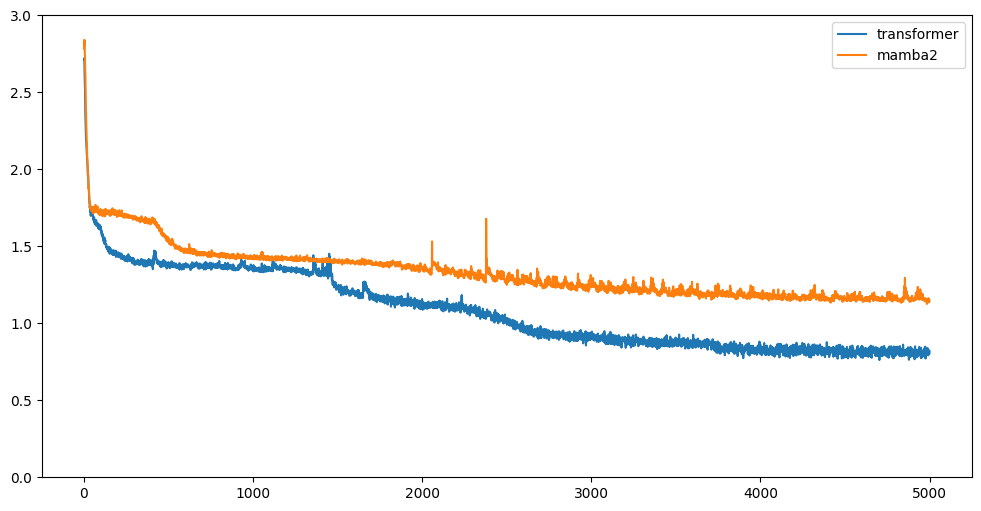

In [ ]:
# constant schedule, peak 3e-4, end 1e-4, warmup 100, steps 5000
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_loss_list)
plt.plot(mamba_loss_list)
plt.legend(['transformer', 'mamba2'])
plt.ylim([0, 3])
plt.show()

In [ ]:
# everything below
# 
# transformer: d_model=256, n_heads=4, n_layers=2
# mamba: d_model=256-24, n_heads=4, n_layers=2

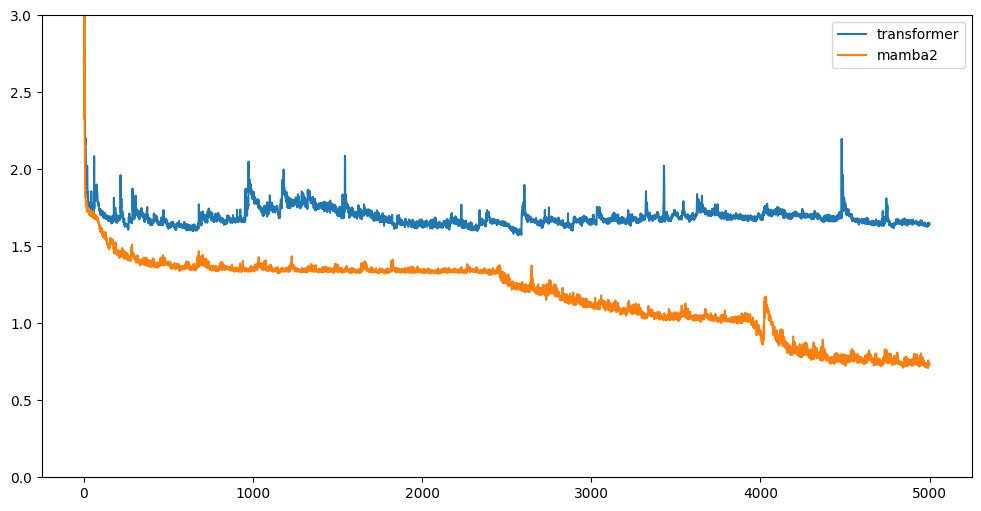

In [ ]:
# constant schedule, 3e-3
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_loss_list)
plt.plot(mamba_loss_list)
plt.legend(['transformer', 'mamba2'])
plt.ylim([0, 3])
plt.show()

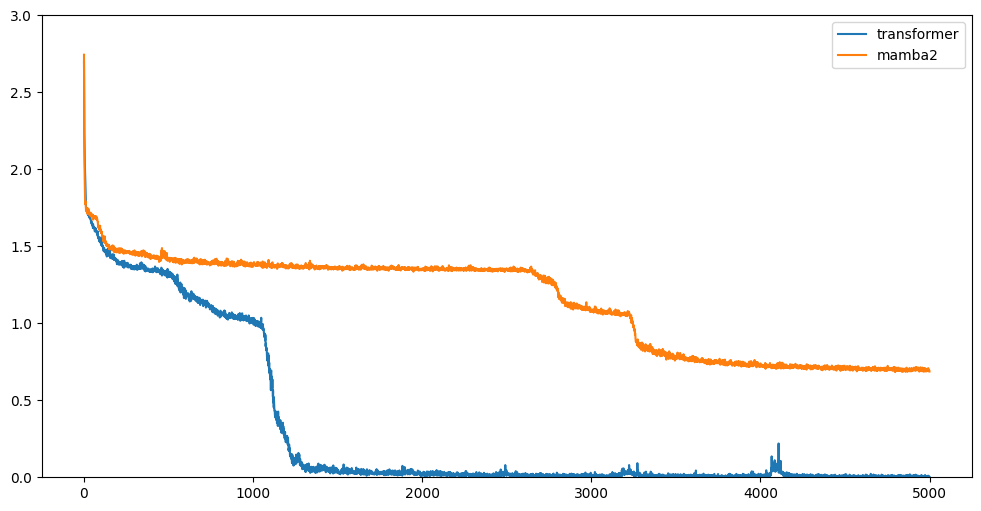

In [ ]:
# constant schedule, 3e-4
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_loss_list)
plt.plot(mamba_loss_list)
plt.legend(['transformer', 'mamba2'])
plt.ylim([0, 3])
plt.show()

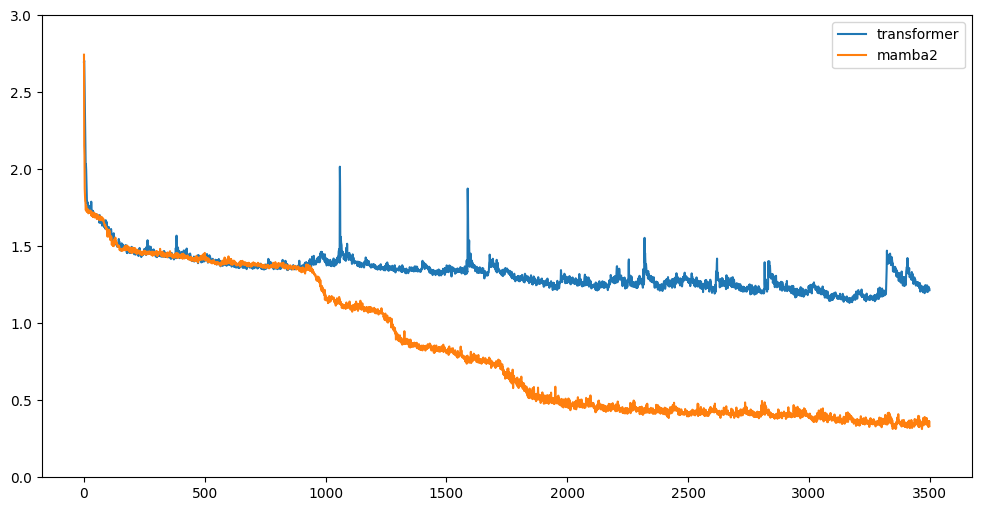

In [ ]:
# constant schedule, 1e-3
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_loss_list)
plt.plot(mamba_loss_list)
plt.legend(['transformer', 'mamba2'])
plt.ylim([0, 3])
plt.show()

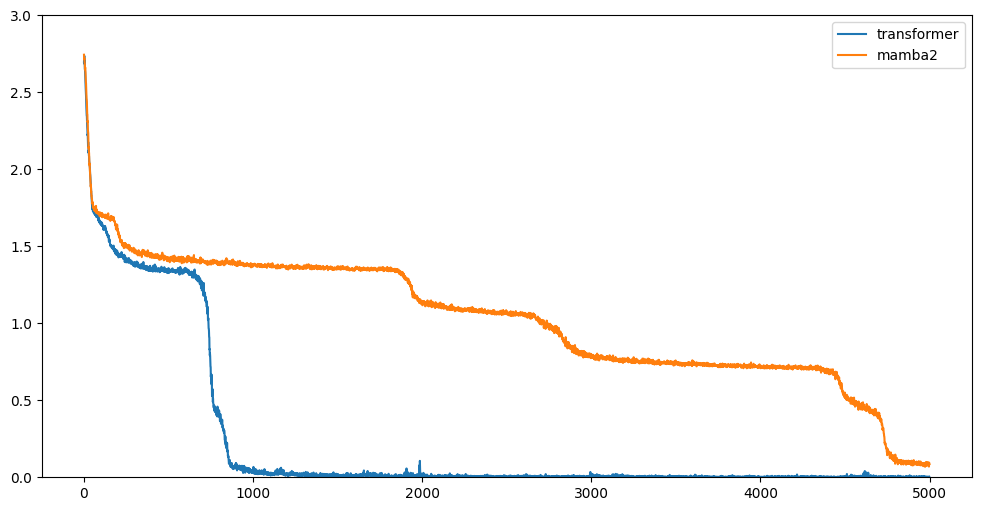

In [ ]:
# cosine schedule, peak 3e-4, end 1e-4, warmup 200, steps 5000
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_loss_list)
plt.plot(mamba_loss_list)
plt.legend(['transformer', 'mamba2'])
plt.ylim([0, 3])
plt.show()

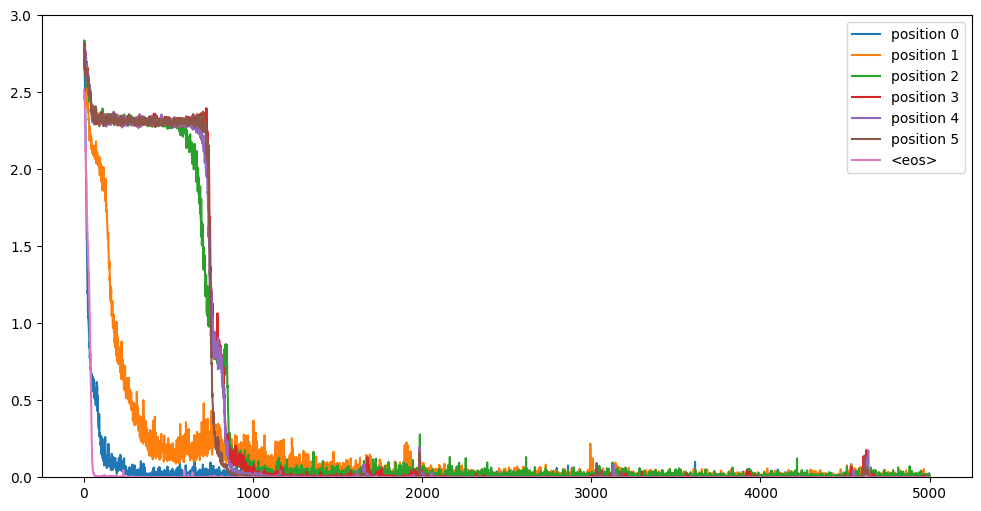

In [ ]:
# per position losses
fig = plt.figure(figsize=(12, 6))
plt.plot(transformer_aux_losses_list)
plt.legend(['position ' + str(i) for i in range(6)] + ['<eos>'])
plt.ylim([0, 3])
plt.show()

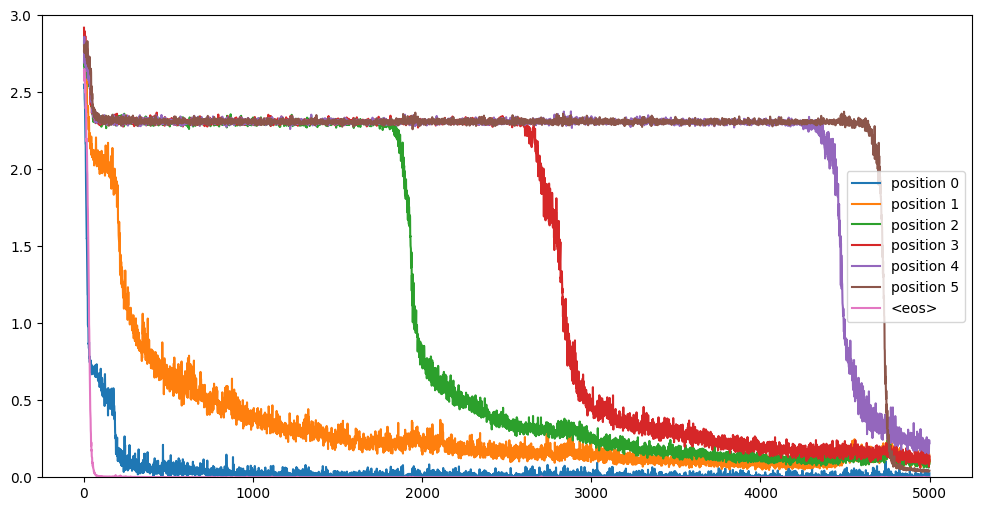

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(mamba_aux_losses_list)
plt.legend(['position ' + str(i) for i in range(6)] + ['<eos>'])
plt.ylim([0, 3])
plt.show()

In [ ]:
first_num = 23249
second_num = 55481

prompt = jnp.array(
    [0] + [ctoi[d] for d in str(first_num)] + [2] + [ctoi[d] for d in str(second_num)] + [3]
)

print('target')
print(str(first_num + second_num).zfill(6) + '<eos>')

print('transformer')
for token in transformer.generate(7, prompt):
    print(itoc[int(token)], end='')
print()

print('mamba2')
for token in mamba.generate(7, prompt):
    print(itoc[int(token)], end='')